In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
from parc.data.data import EnergeticMatDataPipeLine as EmData
from parc import misc, metrics, visualization
from parc.model import model


2023-10-31 17:21:27.298791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 17:21:28.024728: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data pipeline

In [2]:
# Get data and normalization
state_seq_whole, vel_seq_whole = EmData.clip_raw_data(idx_range = (0,150))
state_seq_norm = EmData.data_normalization(state_seq_whole,3)
vel_seq_norm = EmData.data_normalization(vel_seq_whole,2)


ValueError: need at least one array to concatenate

# Training


### Stage 1: Differentiator training

In [ ]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,:3],vel_seq_norm[0][:,:,:,:2]))
dataset_label = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,-3:],vel_seq_norm[0][:,:,:,-2:]))
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)

In [ ]:
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "euler", mode = "differentiator_training")
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 4, shuffle = True)

In [ ]:
parc.differentiator.save_weights('parc2_diff_spade_euler_with_diffusion_term.h5')

### Stage 2: Data-driven integration training

In [ ]:
# Pretrain integrator
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "euler", mode = "integrator_training")
parc.differentiator.load_weights('./parc2_diff_euler.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 50, shuffle = True)

In [ ]:
parc.integrator.save_weights('parc2_int_euler.h5')

In [ ]:
# Define sequence length for training
sequence_length = 13
state_seq_whole, vel_seq_whole = EmData.clip_raw_data(idx_range = (0,150), sequence_length = sequence_length + 1, n_state_var = 3,purpose = "int_training")
state_seq_norm_whole = EmData.data_normalization_test(state_seq_whole,state_seq_norm[1], state_seq_norm[2],3)
vel_seq_norm_whole = EmData.data_normalization_test(vel_seq_whole,vel_seq_norm[1], vel_seq_norm[2],2)

In [ ]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices((state_seq_norm_whole[:,:,:,:3],vel_seq_norm_whole[:,:,:,:2]))
dataset_label = tf.data.Dataset.from_tensor_slices((state_seq_norm_whole[:,:,:,-3:],vel_seq_norm_whole[:,:,:,-2:]))
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 100) 
dataset = dataset.batch(1)

In [ ]:
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = sequence_length, step_size= 1/15, solver = "rk4", mode= "integrator_training")
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0000001, beta_1 = 0.5, beta_2 = 0.999))
parc.differentiator.load_weights('./pretrained_weights/parc2_diff_rk4.h5')
parc.integrator.load_weights('./pretrained_weights/parc2_int_rk4.h5')
# parc.fit(dataset, epochs = 20, shuffle = True)

In [ ]:
parc.integrator.save_weights('parc2_int_euler.h5')

In [9]:
import time
import os
import numpy as np
import skimage
from skimage.measure import block_reduce


def clip_raw_data(idx_range, sequence_length=2, n_state_var=3, purpose = "diff_training"):
    state_seq_whole = []
    vel_seq_whole = []

    for i in range(idx_range[0],idx_range[1]):
        file_path = os.path.join(os.sep,'project','SDS','research', 'Nguyen_storage', 'data', 'single_void_data', f'void_{i}.npy')
        if os.path.exists(file_path):
            raw_data = np.float32(np.load(file_path))
            data_shape = raw_data.shape
            if data_shape[2] > sequence_length:
                print(i)
                npad = ((0, abs(data_shape[0] - 512)), (0, abs(data_shape[1] - 1024)), (0, 0))
                raw_data = np.pad(raw_data, pad_width=npad, mode='edge')
                raw_data = np.expand_dims(raw_data, axis=0)
                raw_data = skimage.measure.block_reduce(raw_data[:,:,:,:], (1,4,4,1),np.max)

                data_shape = raw_data.shape
                num_time_steps = data_shape[-1] // (n_state_var + 2)
                if purpose == "diff_training":
                    j_range = num_time_steps - sequence_length
                else:
                    j_range = 1
                state_seq_case = [np.concatenate([raw_data[:, :, :256, (j + k) * (n_state_var + 2):\
                                                        (j + k) * (n_state_var + 2) + n_state_var] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range  (j_range)] 

                vel_seq_case = [np.concatenate([raw_data[:, :, :256, (j + k) * (n_state_var + 2) +  n_state_var :\
                                                        (j + k) * (n_state_var + 2) + n_state_var + 2] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range (j_range)] 


                state_seq_whole.extend(state_seq_case)
                vel_seq_whole.extend(vel_seq_case)

    state_seq_whole = np.concatenate(state_seq_whole, axis=0)
    vel_seq_whole = np.concatenate(vel_seq_whole, axis=0)

    return state_seq_whole, vel_seq_whole

# Normalization
def data_normalization(input_data,no_of_channel):
    norm_data = np.zeros(input_data.shape)
    min_val = []
    max_val = []
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = ((input_data[:,:,:,i::no_of_channel] - np.amin(input_data[:,:,:,i::no_of_channel])) / (np.amax(input_data[:,:,:,i::no_of_channel]) - np.amin(input_data[:,:,:,i::no_of_channel])) + 1E-9)
        min_val.append(np.amin(input_data[:,:,:,i::no_of_channel]))
        max_val.append(np.amax(input_data[:,:,:,i::no_of_channel]))
    return norm_data, min_val, max_val

def data_normalization_test(input_data, min_val, max_val, no_of_channel):
    norm_data = np.zeros(input_data.shape)
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = ((input_data[:,:,:,i::no_of_channel] - min_val[i]) / (max_val[i] - min_val[i] + 1E-9))
    return norm_data

# Validation

In [11]:
state_seq_whole, vel_seq_whole = clip_raw_data(idx_range = (161,162), sequence_length = 30, n_state_var = 3, purpose = "test")
state_seq_norm_test = data_normalization_test(state_seq_whole, state_seq_norm[1], state_seq_norm[2],3)
vel_seq_norm_test = data_normalization_test(vel_seq_whole, vel_seq_norm[1], vel_seq_norm[2],2)

161


## Load model

In [12]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 30, step_size= 1/15, solver = "rk4", mode= "integrator_training")
parc_rk.compile()
parc_rk.differentiator.load_weights('parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('parc2_int_rk4.h5')

2023-08-15 16:31:58.823939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 16:32:00.965801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


## Field evolution plot

1/1 [==============================] - 5s 5s/step


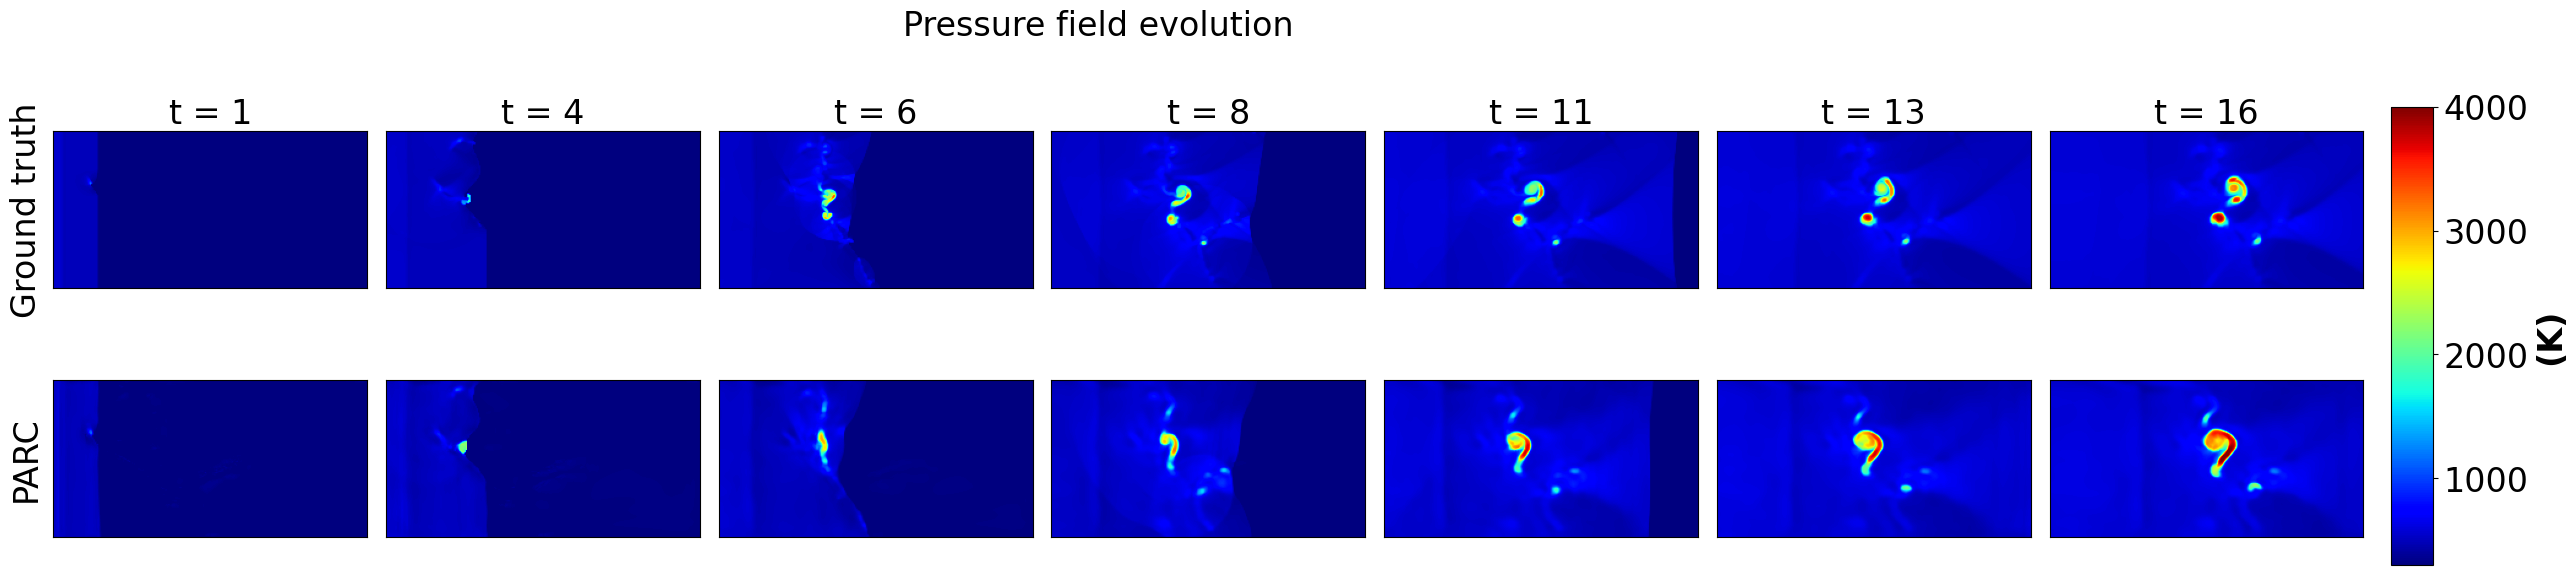

In [15]:
# Make prediction
case_idx = 0
state_var_current = state_seq_norm_test[case_idx:case_idx+1,:,:,0:3]
velocity_current = vel_seq_norm_test[case_idx:case_idx+1,:,:,0:2]
pred_state_rk = parc_rk.predict([state_var_current,velocity_current])
# pred_state_euler = parc_euler.predict([state_var_current,velocity_current])


In [31]:
state_seq_norm_test.shape

(1, 128, 256, 66)

In [66]:
len(pred_state_rk)

30

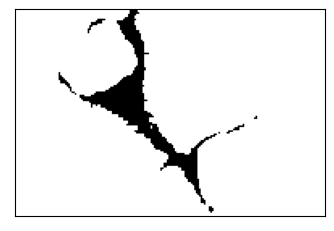

In [25]:
fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(np.squeeze(state_seq_norm_test[case_idx, :, :, 2]), cmap="gray", vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [69]:
import matplotlib as mpl

def plot_field_evolution(y_pred, y_true, state_var_type="temperature"):
    """Visualize the prediction
    :param y_pred:          (numpy) predicted fields
                            [0, ...] predicted fields (F)
                            [1, ...] predicted change of fields (F_dot)
    :param y_true:          (numpy) true label of the fields
    :param test_sample_no:  (int)   array index to select the test case
    :state_var_type:        (str)   indicate which fields to plot the result to apply correct scaling
    """

    # get correct scaling terms
    if state_var_type == "temperature":
        opts = 0
        opts_2 = 0
        step = 6
        min_val = 300  # min temperature (K)
        max_val = 4000  # max temperature (K)
        unit = "(K)"
    elif state_var_type == "pressure":
        opts = 1
        opts_2 = 1
        step = 6
        min_val = -2  # min pressure (GPa)
        max_val = 50  # max pressure (GPa)
        unit = "(GPa)"
    elif state_var_type == "vel_x":
        opts = 0
        opts_2 = 3
        step = 4
        min_val = -1739.868  # min vel (m/s)
        max_val = 9278.142  # max vel (m/s)
        unit = "(m/s)"
    elif state_var_type == "vel_y":
        opts = 1
        opts_2 = 4
        step = 4
        min_val = -4335.711  # min vel (m/s)
        max_val = 5491.27  # max vel (m/s)
        unit = "(m/s)"
    else:
        print(
            state_var_type,
            " is not supported. Choose either 'temperature' or 'pressure'.",
        )
        return None

    # plot the prediction results
    x_num = np.linspace(0, 20, 21)  # discrete timesteps
    fig, ax = plt.subplots(4, 5, figsize=(25, 15))
    plt.subplots_adjust(wspace=0.06, hspace=0.07, top=0.85)
#     fig.suptitle("Pressure field evolution ", fontsize=24)
    for i in range(5):
        ax[0][i].clear()
        ax[0][i].clear()
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        im = ax[0][i].imshow(
            np.squeeze(y_true[0, :, :, (i) * step + opts]),
            cmap="jet",
            vmin=0,
            vmax=0.8,
        )
        ax[0][i].set_title(("t = " + "%d" % (x_num[i*2]+1)), fontsize=24)

        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        ax[1][i].imshow(
            np.squeeze(y_pred[i*2][0, :, :, opts_2]),
            cmap="jet",
            vmin=0,
            vmax=0.8,
        )
        
        ax[2][i].clear()
        ax[2][i].clear()
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        im = ax[2][i].imshow(
            np.squeeze(y_true[0, :, :, (i+5) * step + opts]),
            cmap="jet",
            vmin=0,
            vmax=0.8,
        )
        
        ax[2][i].set_title(("t = " + "%d" % (x_num[i*2]+11)), fontsize=24)

        ax[3][i].set_xticks([])
        ax[3][i].set_yticks([])
        ax[3][i].imshow(
            np.squeeze(y_pred[i*2+11][0, :, :, opts_2]),
            cmap="jet",
            vmin=0,
            vmax=0.8,
        )
        
    ax[0][0].set_ylabel("Ground truth", fontsize=24)
    ax[1][0].set_ylabel("PARC", fontsize=24)
    ax[2][0].set_ylabel("Ground truth", fontsize=24)
    ax[3][0].set_ylabel("PARC", fontsize=24)
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.96, 0.128, 0.015, 0.7])
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap="jet"), cax=cbar_ax, ax=im
    )
    cbar.set_label(label=unit, weight="bold", fontsize=24)
    cbar.ax.tick_params(labelsize=24)
    plt.show()

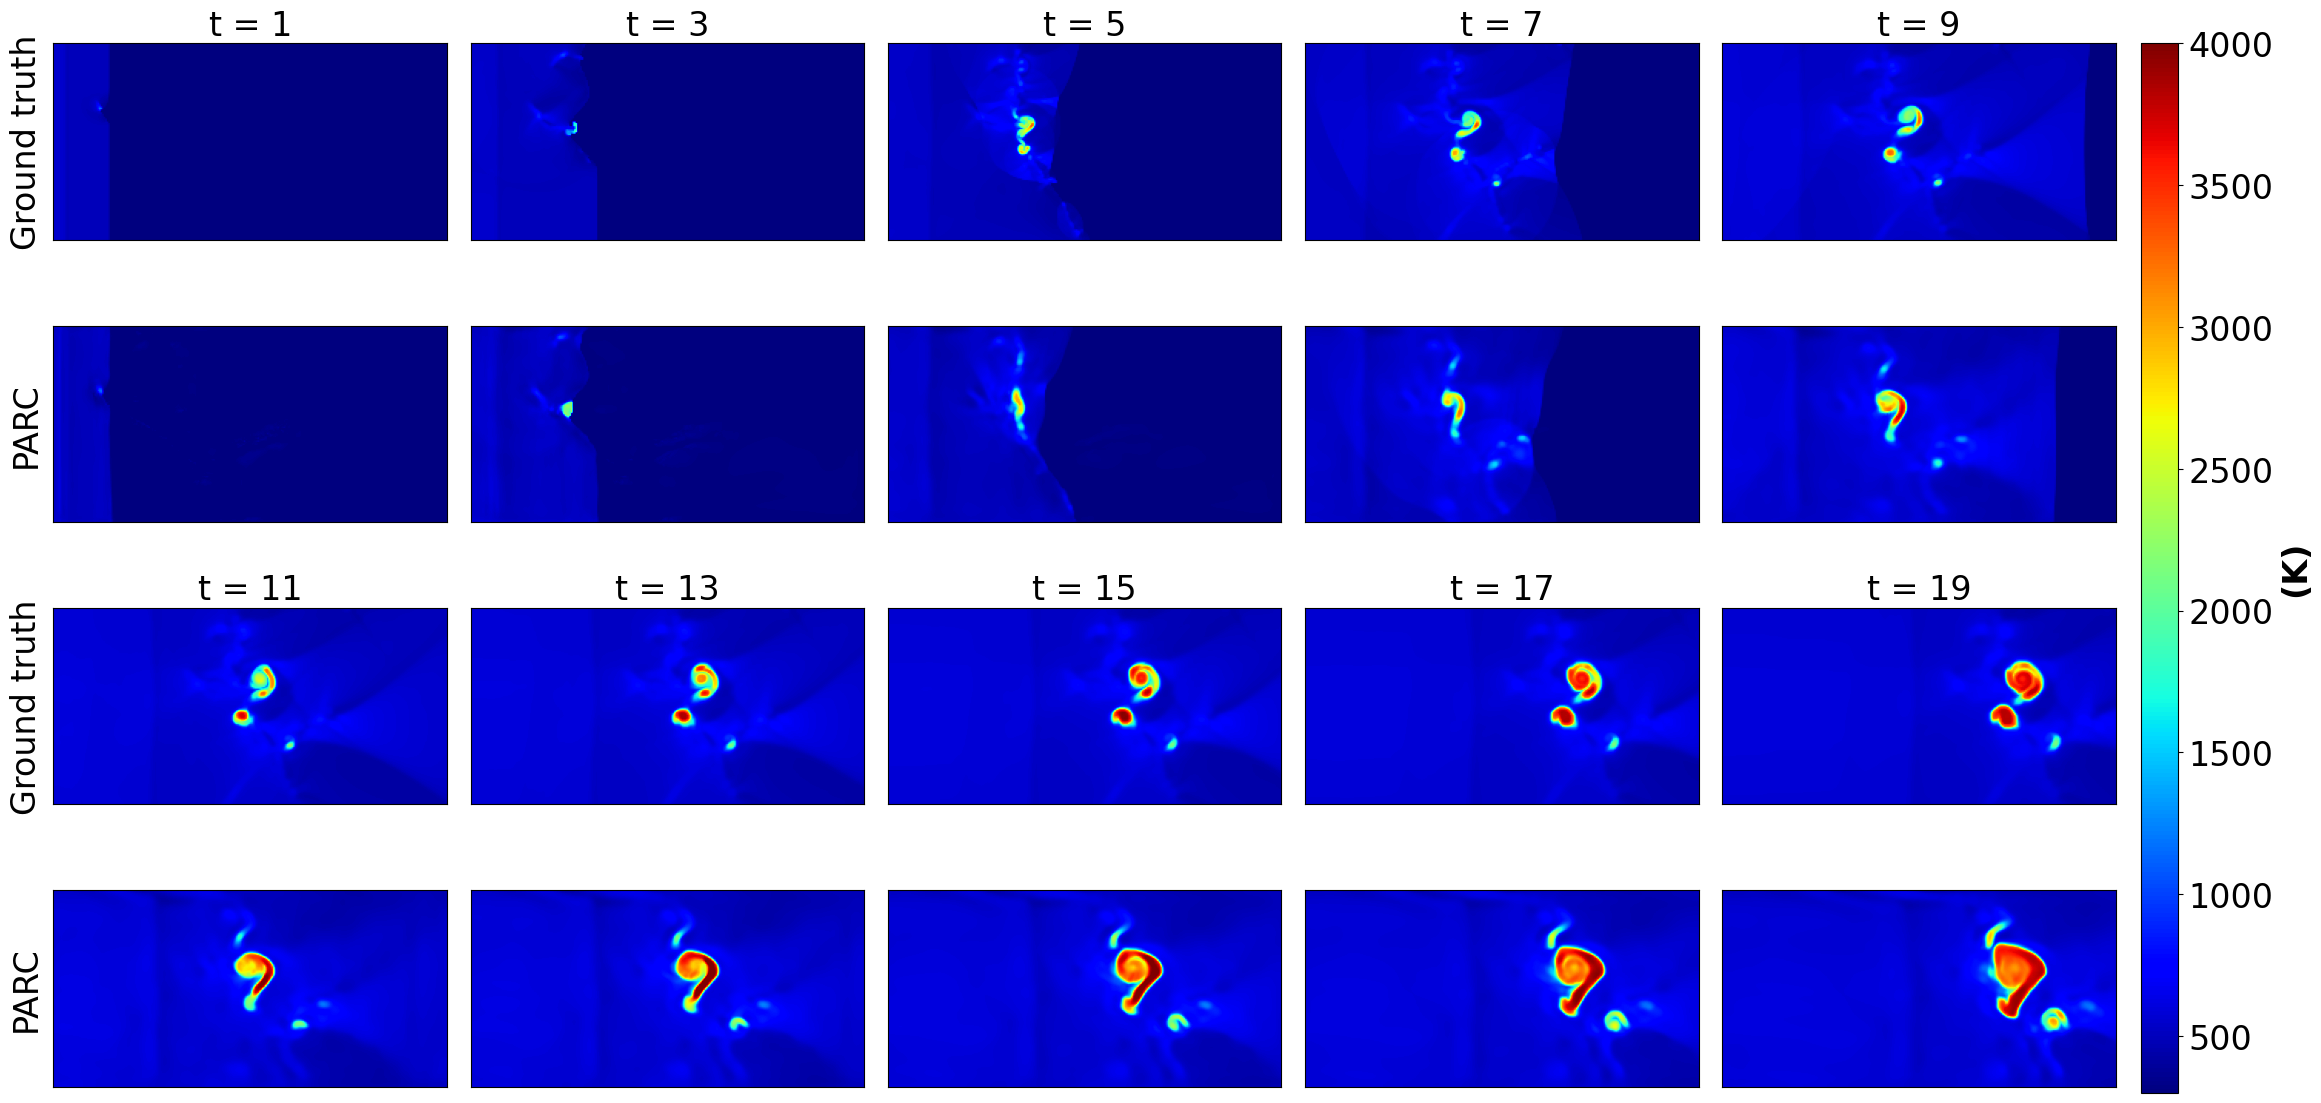

In [70]:
plot_field_evolution(pred_state_rk, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="temperature")

### Temperature

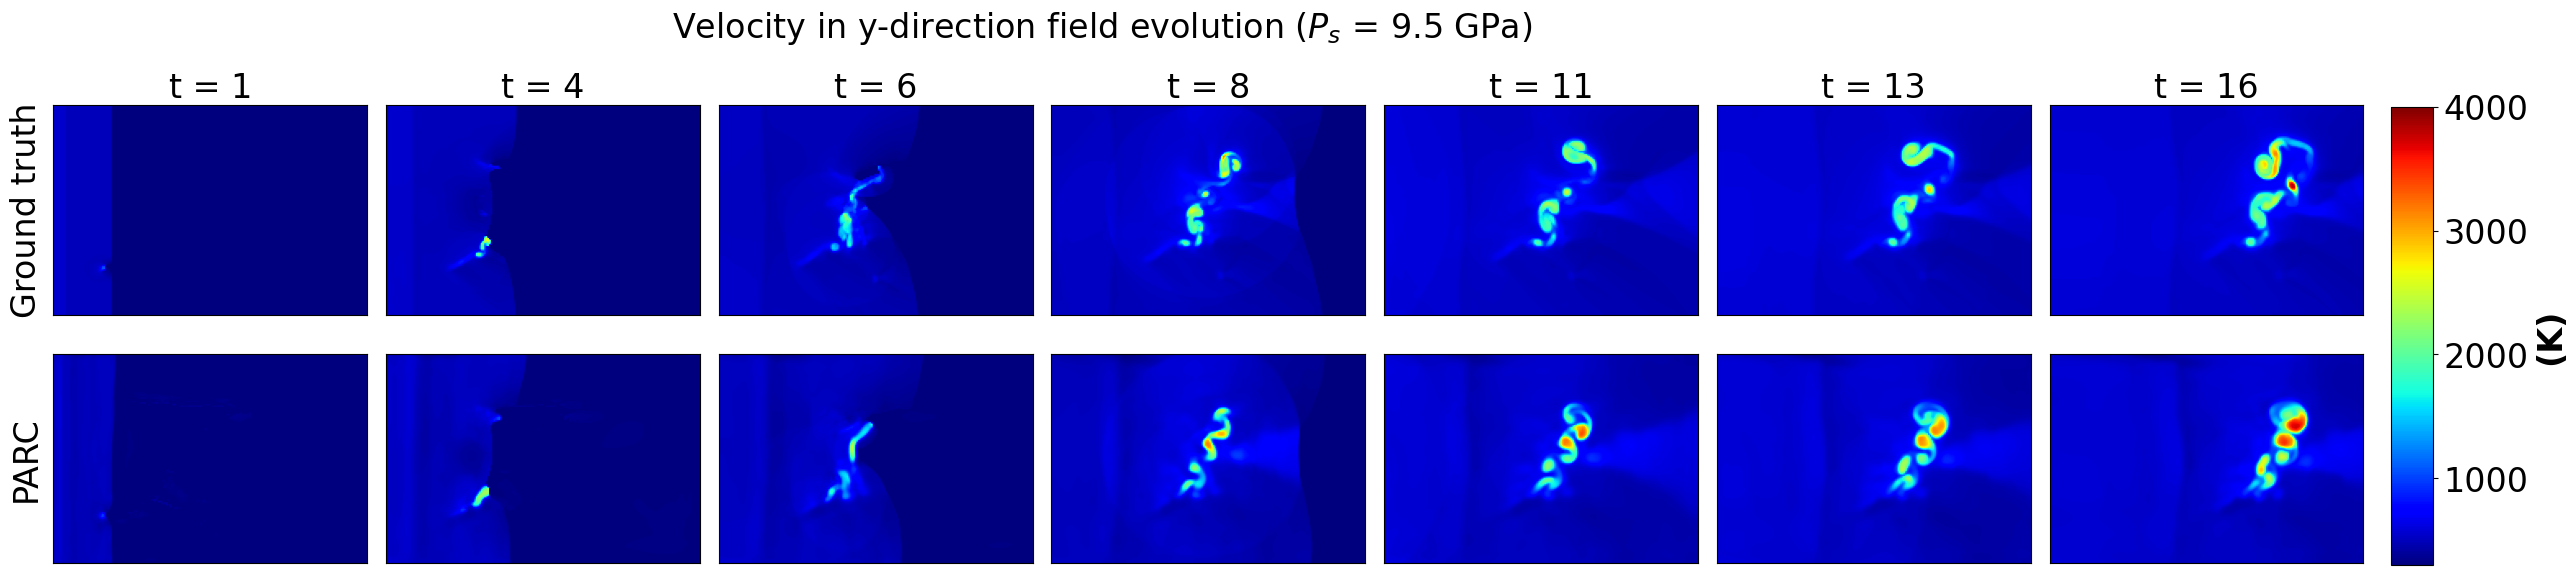

In [12]:
plot_field_evolution(pred_state_rk, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="temperature")

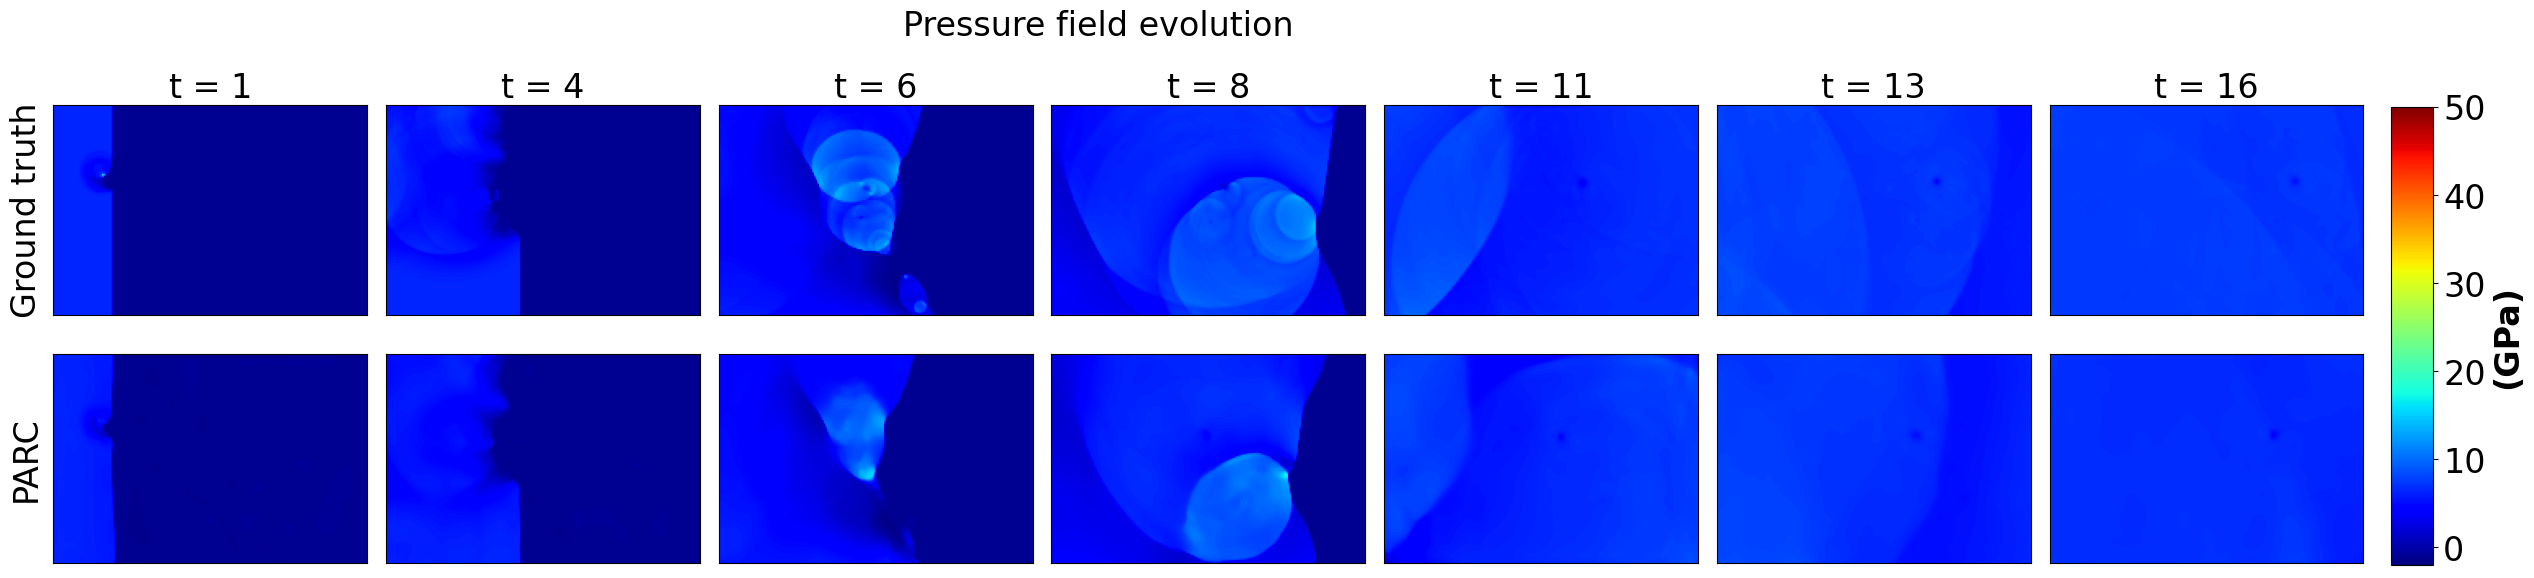

In [28]:
plot_field_evolution(pred_state_rk, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="pressure")

### Pressure

In [12]:
plot_field_evolution(pred_state, state_seq_norm_test[case_idx:case_idx+1,:,:,3:], state_var_type="pressure")

NameError: name 'pred_state' is not defined

### Velocity in x direction

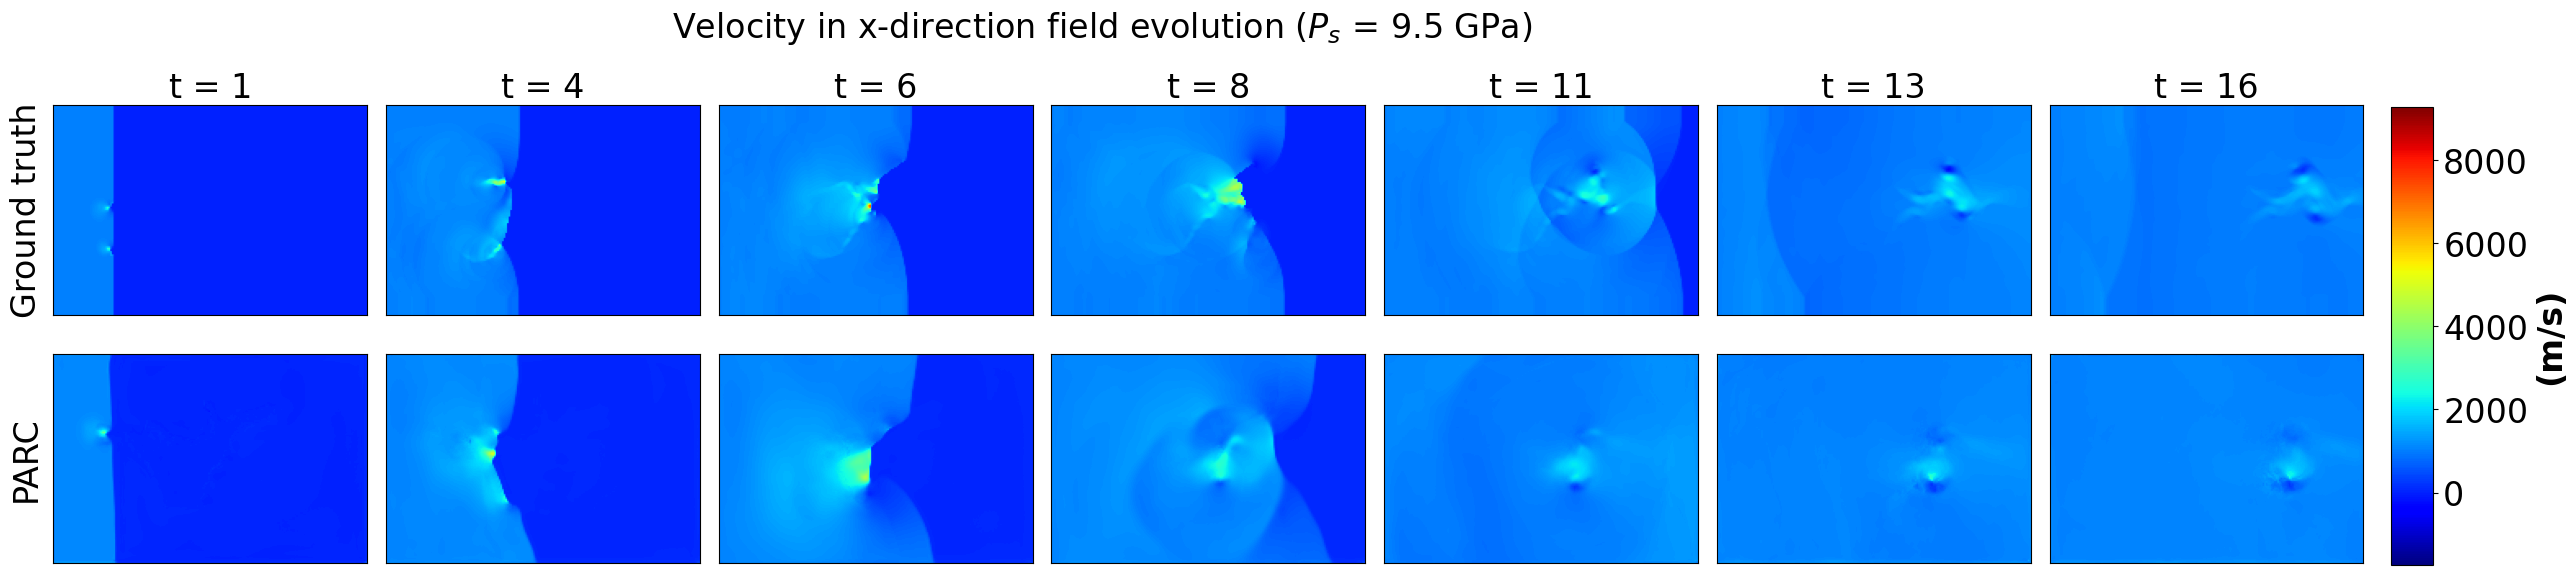

In [193]:
plot_field_evolution(pred_state, vel_seq_norm_test[case_idx:case_idx+1,:,:,2:], state_var_type="vel_x")

### Velocity in y direction

In [85]:
plot_field_evolution(pred_state, vel_seq_norm_test[case_idx:case_idx+1,:,:,2:], state_var_type="vel_y")

NameError: name 'pred_state' is not defined

In [14]:
Temp_gt = np.delete(state_seq_norm_test, outlier, 0)

Temp_gt = Temp_gt[:,:,:,3::3]    # Ground truth temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_rk = state_rk[:,:,:,0::5]   # PARC prediction temperature field evolution
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 5000, min_temp = 300)


In [16]:
hs_field_gt = Temp_gt > 850
parc_hs_field = Temp_pred_parc_rk > 850

In [42]:
hs_field_gt.shape

(25, 128, 192, 17)

In [ ]:
for i in range(15):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.squeeze(Temp_gt[21,:,:,i]))
    ax[1].imshow(np.squeeze(Temp_pred_parc_rk[21,:,:,i]))
    plt.show()

### Quantitative analysis

In [110]:
state_rk = []
outlier = [0, 3, 30, 31, 32, 33, 18, 19, 11]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

1
1/1 [==============================] - 1s 740ms/step
(1, 128, 192, 75)
2
1/1 [==============================] - 1s 723ms/step
(1, 128, 192, 75)
4
1/1 [==============================] - 1s 725ms/step
(1, 128, 192, 75)
5
1/1 [==============================] - 1s 723ms/step
(1, 128, 192, 75)
6
1/1 [==============================] - 1s 723ms/step
(1, 128, 192, 75)
7
1/1 [==============================] - 1s 722ms/step
(1, 128, 192, 75)
8
1/1 [==============================] - 1s 722ms/step
(1, 128, 192, 75)
9
1/1 [==============================] - 1s 723ms/step
(1, 128, 192, 75)
10
1/1 [==============================] - 1s 723ms/step
(1, 128, 192, 75)
12
1/1 [==============================] - 1s 723ms/step
(1, 128, 192, 75)
13
1/1 [==============================] - 1s 722ms/step
(1, 128, 192, 75)
14
1/1 [==============================] - 1s 723ms/step
(1, 128, 192, 75)
15
1/1 [==============================] - 1s 724ms/step
(1, 128, 192, 75)
16
1/1 [==============================] - 1s 7

In [111]:
state_euler = []
outlier = [0, 3, 30, 31, 32, 33, 18, 19, 11]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_euler.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_euler.append(pred_state_case)
state_euler = np.concatenate(state_euler, axis = 0)
print(state_euler.shape)       

1
1/1 [==============================] - 0s 284ms/step
(1, 128, 192, 75)
2
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
4
1/1 [==============================] - 0s 281ms/step
(1, 128, 192, 75)
5
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
6
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
7
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
8
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
9
1/1 [==============================] - 0s 281ms/step
(1, 128, 192, 75)
10
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
12
1/1 [==============================] - 0s 281ms/step
(1, 128, 192, 75)
13
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
14
1/1 [==============================] - 0s 280ms/step
(1, 128, 192, 75)
15
1/1 [==============================] - 0s 281ms/step
(1, 128, 192, 75)
16
1/1 [==============================] - 0s 2

In [196]:
def plot_sensitivity(y_true, y_pred_euler, y_pred_rk, metric, ts):
    """sensitivity plot comparing true and prediction
    :param y_true:  (tuple)
    :param y_pred:  (tuple)
    :param metric:  (str)   metric for plotting. {hs_temp, hs_area, rate_hs_temp, rate_hs_area}
    """

    if metric == "hs_temp" or metric == "hs_area":
        ts = np.linspace(3.16, 15.01, ts)
    elif metric == "rate_hs_temp" or metric == "rate_hs_area":
        ts = np.linspace(3.16, 14.22, ts - 1)
    else:
        print(
            "Wrong metric selection. Possible metrics are: 'hs_temp', 'hs_area', 'rate_hs_temp', 'rate_hs_area"
        )

    col_true, col_pred, col_yel = "#277DA1", "#F94144", "#F9C74F"
    plt.figure(figsize=(13, 10))

    # mean values
    plt.plot(ts, y_true[0], color=col_true, lw=2.5, label="Ground truth")
    plt.plot(ts, y_pred_rk[0], color=col_pred, lw=2.5, label="PARC-RK4")
#     plt.plot(ts, y_pred_euler[0], color=col_yel, lw=2.5, label="PARC-Euler")

    # plot intervals
    plt.fill_between(ts, y_true[1], y_true[2], color=col_true, alpha=0.2)
    plt.fill_between(ts, y_pred_rk[1], y_pred_rk[2], color=col_pred, alpha=0.2)
#     plt.fill_between(ts, y_pred_euler[1], y_pred_euler[2], color=col_yel, alpha=0.2)

    # corresponding titles and wordings based on the metric
    if metric == "hs_temp":
        plt.title(r"Ave. Hotspot Temperature ($T_{hs}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r" $T_{hs}$ ($K$)", fontsize=28)
        plt.axis([3.16, 15.01, 0, 5000])
    elif metric == "hs_area":
        plt.title(r"Hotspot Area ($A_{hs}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$A_{hs}$ ", fontsize=28)
        plt.axis([3.16, 15.01, 0, 25])
    elif metric == "rate_hs_temp":
        plt.title(
            r"Ave. Hotspot Temperature Rate of Change ($\dot{T_{hs}}$)",
            fontsize=32,
            pad=15,
        )
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$\dot{T_{hs}}$ ($K$/$ns$)", fontsize=28)
        plt.axis([3.16, 15.01, -30, 1200])
    else:
        plt.title(r"Hotspot Area Rate of Change ($\dot{A_{hs}}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$\dot{A_{hs}}$", fontsize=28)
        plt.axis([3.16, 15.01, 0, 10])

    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.legend(loc=2, fontsize=28)
    plt.show()


In [114]:
## Preprocess temperature data
# Get temperature field evolution
# Temp_gt = np.delete(state_seq_norm_test, outlier, 0)
# Temp_gt = Temp_gt[:,:,:,3::3]    # Ground truth temperature field evolution
Temp_gt = state_seq_norm_test[:,:,:,3::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
Temp_pred_parc_rk = state_rk[:,:,:,0::5]   # PARC prediction temperature field evolution
Temp_pred_parc_euler = state_euler[:,:,:,0::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_euler = misc.scale_temperature(temperatures = Temp_pred_parc_euler, start_ts = 0, max_temp = 5000, min_temp = 300)

# Compute sensitivity of ground truth data
gt_hs_temp, gt_hs_area = metrics.calculate_hotspot_metric(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)
gt_rate_hs_temp,gt_rate_hs_area = metrics.calculate_hotspot_metric_rate_of_change(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_rk, parc_hs_area_rk = metrics.calculate_hotspot_metric(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_rk, parc_rate_hs_area_rk = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_euler, parc_hs_area_euler = metrics.calculate_hotspot_metric(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_euler, parc_rate_hs_area_euler = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

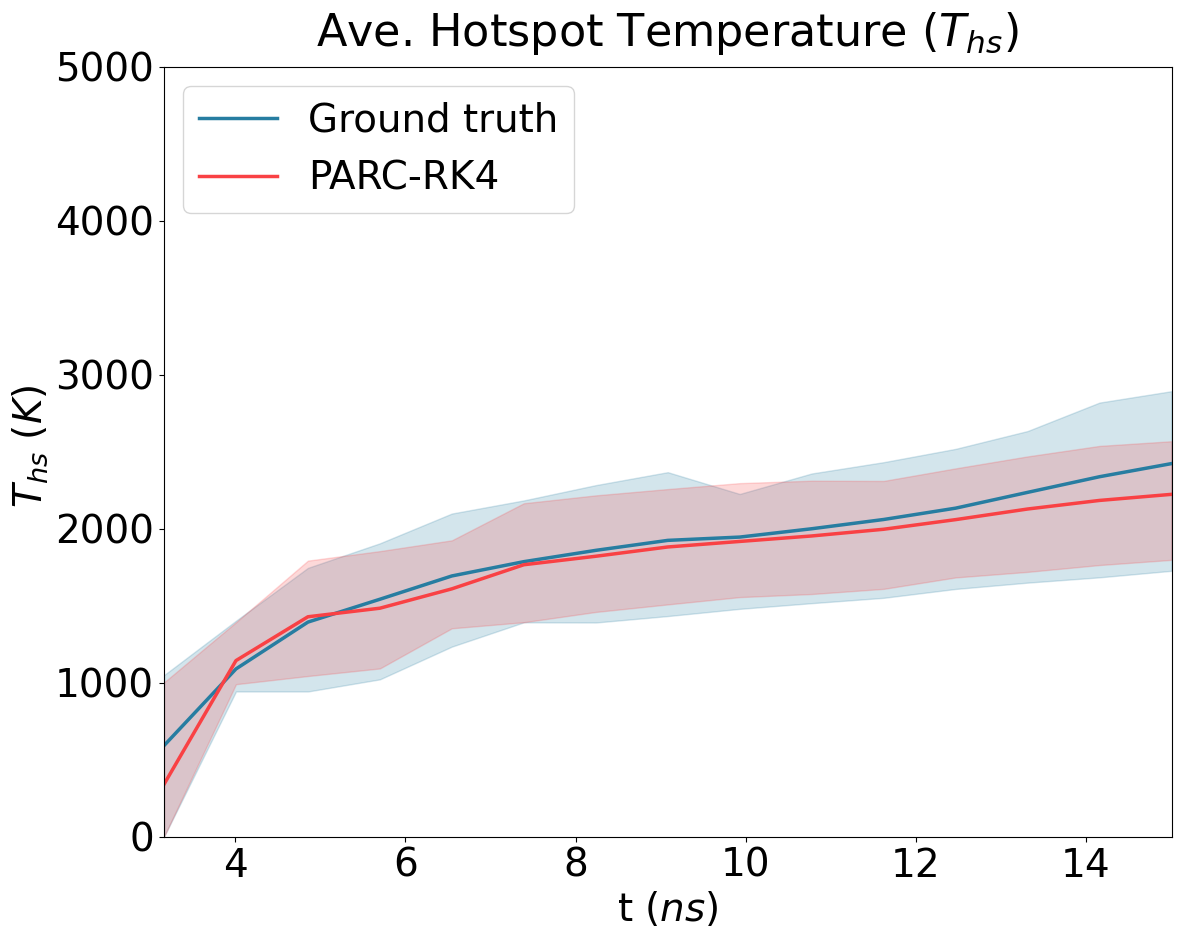

In [197]:
plot_sensitivity(y_true=gt_hs_temp, y_pred_rk=parc_hs_temp_rk, y_pred_euler = parc_hs_temp_euler,  metric='hs_temp',ts=15)

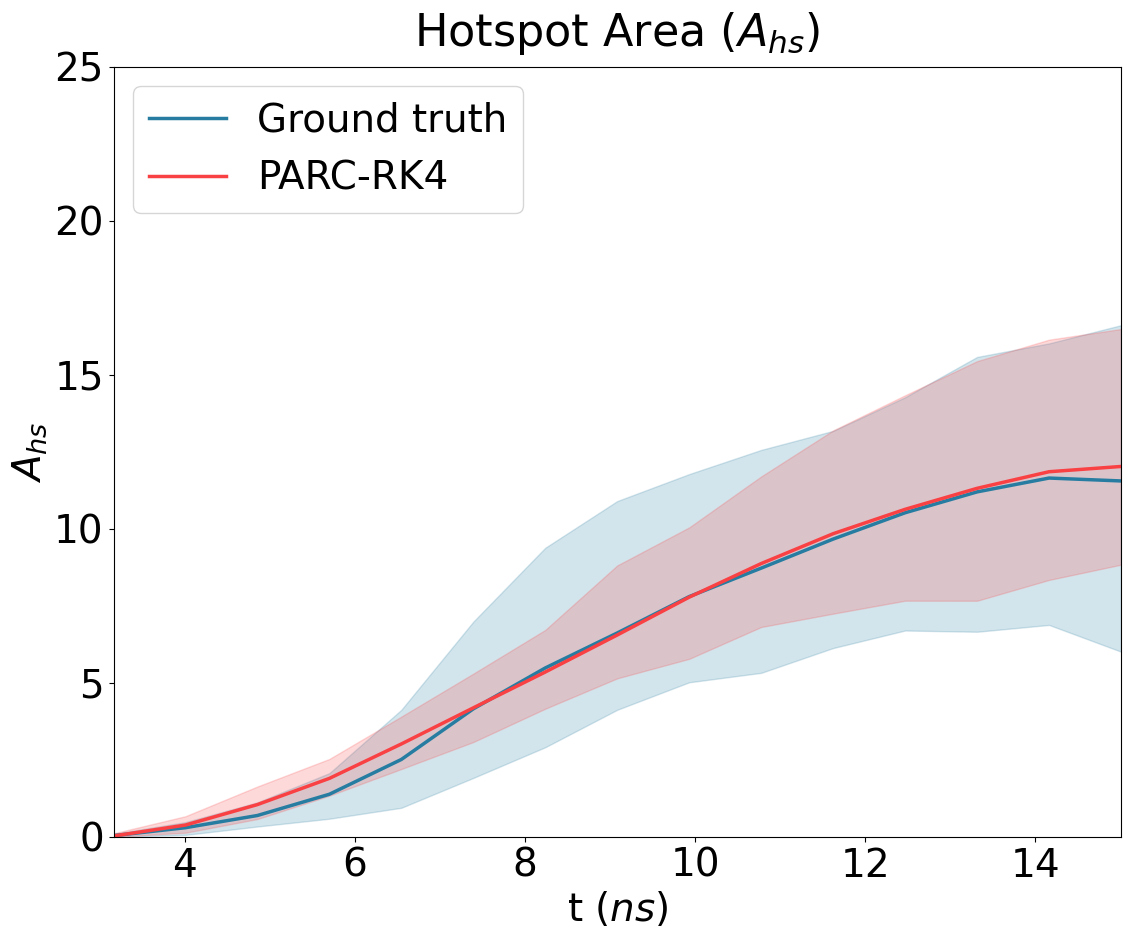

In [198]:
plot_sensitivity(y_true=gt_hs_area, y_pred_rk=parc_hs_area_rk, y_pred_euler = parc_hs_area_euler, metric='hs_area',ts=15)

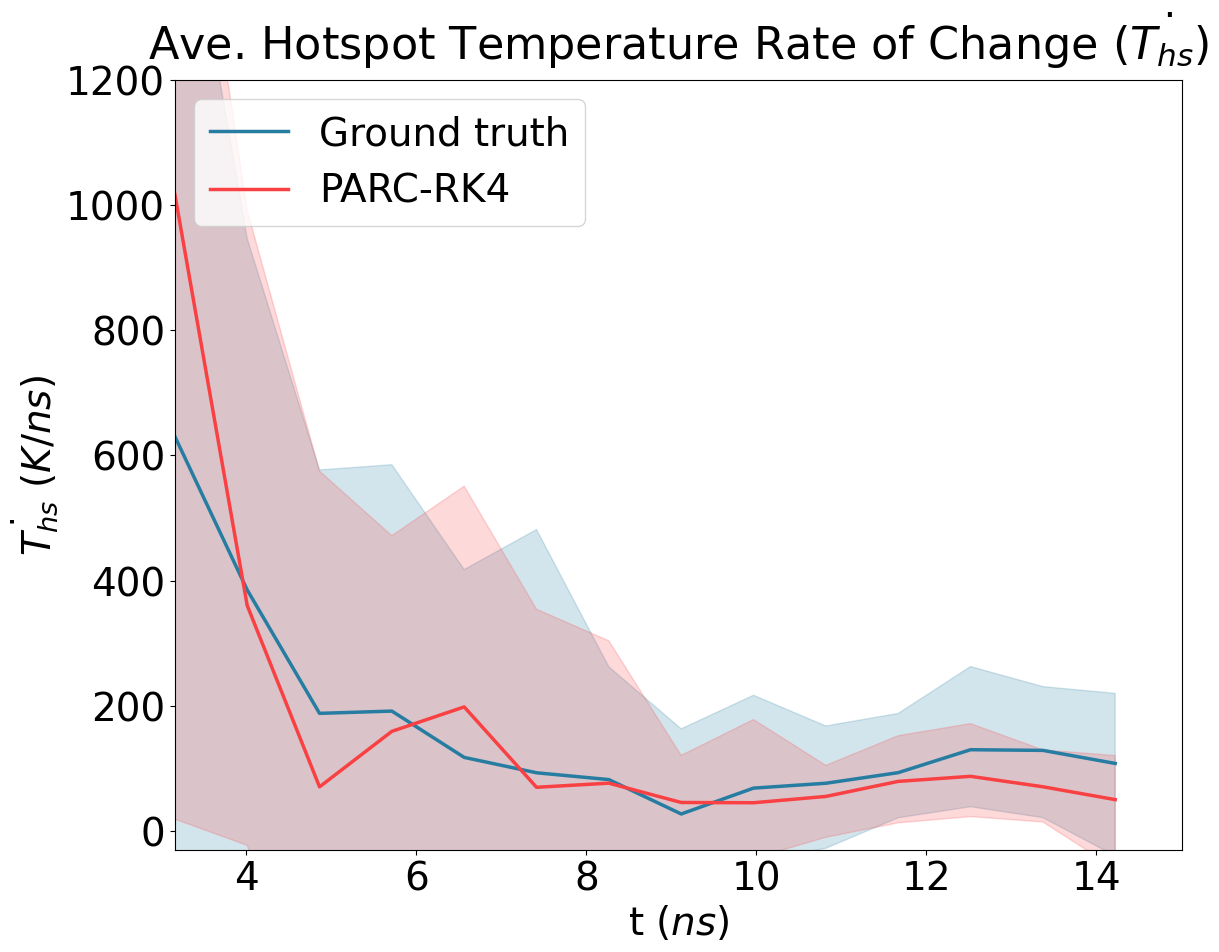

In [199]:
plot_sensitivity(y_true=gt_rate_hs_temp, y_pred_rk=parc_rate_hs_temp_rk, y_pred_euler = parc_rate_hs_temp_euler, metric='rate_hs_temp',ts=15)

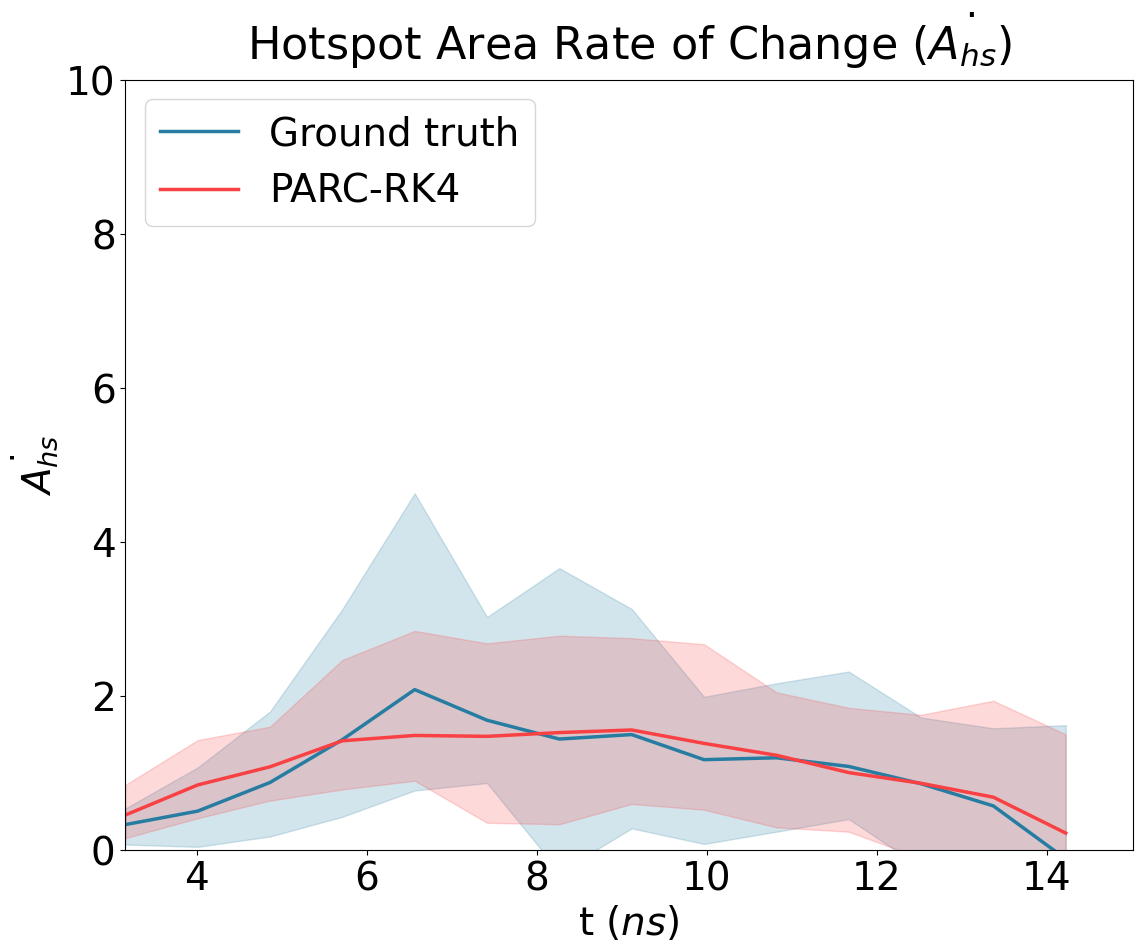

In [200]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)

In [202]:
## Preprocess temperature data
# Get temperature field evolution
# Temp_gt = np.delete(state_seq_norm_test, outlier, 0)
# Temp_gt = Temp_gt[:,:,:,3::3]    # Ground truth temperature field evolution
P_gt = vel_seq_norm_test[:,:,:,4::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
P_pred_parc_rk = state_rk[:,:,:,1::5]   # PARC prediction temperature field evolution
Temp_pred_parc_euler = state_euler[:,:,:,0::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 50e9, min_temp = -2e9)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 50e9, min_temp = -2e9)
Temp_pred_parc_euler = misc.scale_temperature(temperatures = Temp_pred_parc_euler, start_ts = 0, max_temp = 5000, min_temp = 300)

In [ ]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)

In [ ]:
    if state_var_type == "temperature":
        opts = 0
        opts_2 = 0
        step = 6
        min_val = 300  # min temperature (K)
        max_val = 5000  # max temperature (K)
        unit = "(K)"
    elif state_var_type == "pressure":
        opts = 1
        opts_2 = 1
        step = 6
        min_val = -2  # min pressure (GPa)
        max_val = 50  # max pressure (GPa)
        unit = "(GPa)"
    elif state_var_type == "vel_x":
        opts = 0
        opts_2 = 3
        step = 4
        min_val = -1739.868  # min vel (m/s)
        max_val = 9278.142  # max vel (m/s)
        unit = "(m/s)"
    elif state_var_type == "vel_y":
        opts = 1
        opts_2 = 4
        step = 4
        min_val = -4335.711  # min vel (m/s)
        max_val = 5491.27  # max vel (m/s)
        unit = "(m/s)"